# How well do we predict extremes?

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [4]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


# Read in the data

In [5]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [6]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 64.45 52.16 97.37 96.48 ... nan nan nan

In [7]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

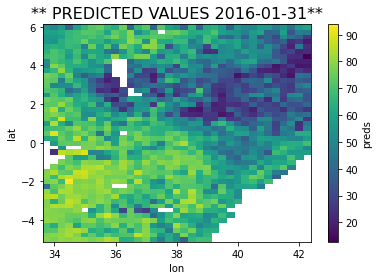

In [8]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

### Load in the models

In [246]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

16

# Errors

In [249]:
from src.analysis.evaluation import (r2_score, rmse, spatial_rmse, spatial_r2)

# load the static data

In [10]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
print(f"N Vars: {len(list(static_data.data_vars))}")
static_data

N Vars: 29


<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lat                                         (lat) float32 6.0 5.75 ... -5.0
  * lon                                         (lon) float32 33.75 ... 42.25
Data variables:
    precip_global_mean                          (lat, lon) float64 ...
    E_global_mean                               (lat, lon) float64 ...
    SMroot_global_mean                          (lat, lon) float64 ...
    SMsurf_global_mean                          (lat, lon) float64 ...
    pev_global_mean                             (lat, lon) float64 ...
    t2m_global_mean                             (lat, lon) float64 ...
    precip_pixel_mean                           (lat, lon) float64 ...
    E_pixel_mean                                (lat, lon) float64 ...
    SMroot_pixel_mean                           (lat, lon) float64 ...
    SMsurf_pixel_mean                           (lat, lon) float64 ...
    pev_pixel_mean                              (lat, lon) float64 ...
    t2m_pixel_mean                              (lat, lon) float64 ...
    topography                                  (lat, lon) float32 ...
    lc_class                                    (lat, lon) float64 ...
    lc_class_group                              (lat, lon) int64 ...
    no_data_one_hot                             (lat, lon) float64 ...
    cropland_rainfed_one_hot                    (lat, lon) float64 ...
    herbaceous_cover_one_hot                    (lat, lon) float64 ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    lichens_and_mosses_one_hot                  (lat, lon) float64 ...
    urban_areas_one_hot                         (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...
    water_bodies_one_hot                        (lat, lon) float64 ...
    permanent_snow_and_ice_one_hot              (lat, lon) float64 ...
    slt                                         (lat, lon) float64 ...

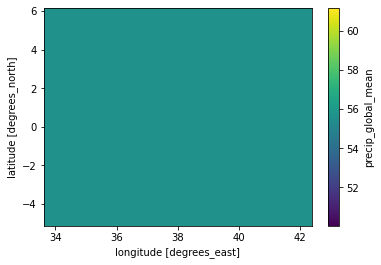

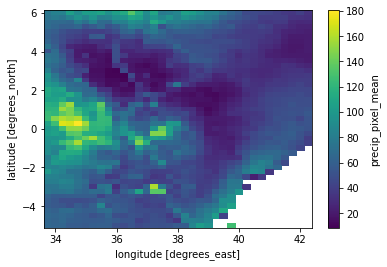

In [11]:
global_vars = [v for v in static_data if 'global' in v]
pixel_vars = [v for v in static_data if 'pixel' in v]

fig, ax = plt.subplots()
static_data[global_vars[0]].plot(ax=ax)
fig, ax = plt.subplots()
static_data[pixel_vars[0]].plot(ax=ax)

# load in the region da
```python
from src.exporters import KenyaAdminExporter
exp = KenyaAdminExporter(data_dir)
exp.export()
```

In [12]:
# from src.preprocess import KenyaAdminPreprocessor
# proc = KenyaAdminPreprocessor(data_dir)
# proc.preprocess(selection='level_2', reference_nc_filepath=data_dir/'interim/chirps_preprocessed/data_kenya.nc')

In [13]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)
r = RegionGeoPlotter(data_dir)

region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm']
Regions: ['province_l1_kenya.nc']
Region Type: administrative_boundaries
The RegionGeoPlotter requires `geopandas` to be installed.
GroupbyRegion requires geopandas to be installed


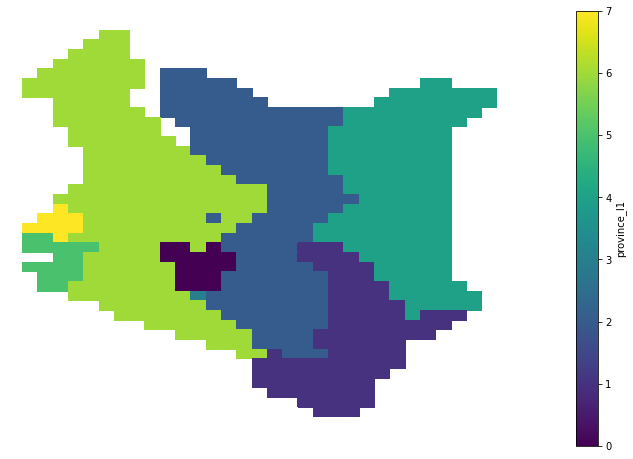

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
region_da.plot(ax=ax)
ax.set_axis_off()

# region_da.where(region_da == dict(zip(region_lookup.values(), region_lookup.keys()))['NAIROBI'])

# Compare for the extremes

In [15]:
y_pred = ealstm_pred.compute()
y_true = ds['VCI'].sel(time=y_pred.time)
assert y_pred.shape == y_true.shape

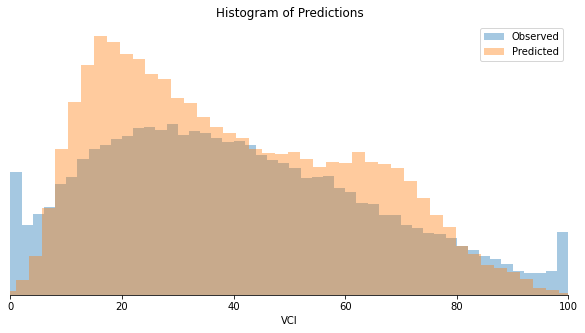

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.distplot(
    np.sort(drop_nans_and_flatten(y_true)), 
    label='Observed',
    kde_kws=dict(kernel='gau', clip=(0, 100)),
    kde=False,
)
sns.distplot(
    np.sort(drop_nans_and_flatten(y_pred)), 
    label='Predicted',
    kde_kws=dict(kernel='gau', clip=(0, 100)),
    kde=False,
)

ax.set_xlabel('VCI')
ax.set_xlim(0, 100);
ax.set_yticks([])
ax.set_yticklabels([])
# ax.set_ylabel('Pixel Count')
ax.legend();

ax.set_title('Histogram of Predictions')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# What about predicting EVENTS ?
```
VCI3M Limits   | Description                        | Value
-----------------------------------------------------------
0 <= x <10     | Extreme vegetation deficit         |  1
10 <= x <20    | Severe vegetation deficit          |  2
20 <= x <35    | Moderate vegetation deficit        |  3
35 <= x <50    | Normal vegetation conditions       |  4
50 <= x <=100  | Above normal vegetation conditions |  5
```

### Calculate VDI

In [17]:
from src.analysis import VegetationDeficitIndex

v = VegetationDeficitIndex(
    data_dir / 'interim/VCI_preprocessed/data_kenya.nc',
    rolling_window=3
)
vdi_obs = v.vegetation_index_classify(y_true, 'vdi')
vdi_pred = v.vegetation_index_classify(y_pred, 'vdi')

In [18]:
print("Overall Metrics")
print("---------------")
print(
    "Correct Classification:".ljust(30), f"{(vdi_obs == vdi_pred).mean().values:.2f}"
)
print(
    "Out by 1:".ljust(30), f"{(abs(vdi_obs - vdi_pred) == 1).mean().values:.2f}"
)
print(
    "Out by 2:".ljust(30), f"{(abs(vdi_obs - vdi_pred) == 2).mean().values:.2f}"
)
print(
    "Out by 3:".ljust(30), f"{(abs(vdi_obs - vdi_pred) == 3).mean().values:.2f}"
)
print("NOTE: bad metric because we have unbalanced class sizes")

Overall Metrics
---------------
Correct Classification:        0.43
Out by 1:                      0.34
Out by 2:                      0.17
Out by 3:                      0.05
NOTE: bad metric because we have unbalanced class sizes


In [19]:
# vdi_obs

### Confusion Matrix

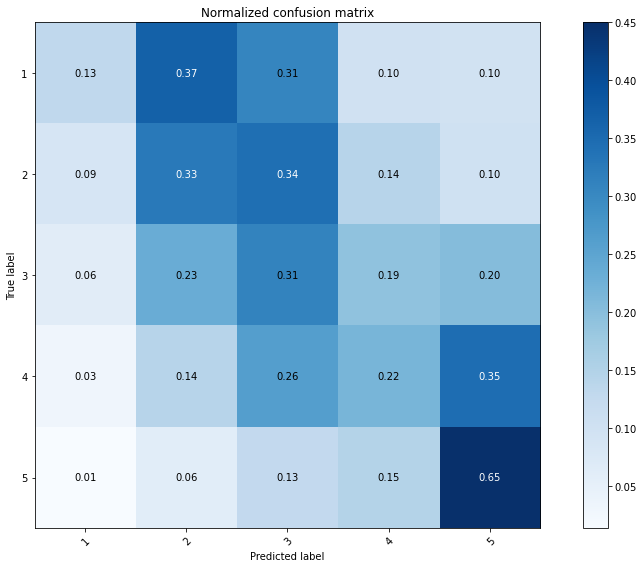

In [22]:
from scripts.drafts.plot_confusion import vdi_confusion_matrix

ax, conf_mat = vdi_confusion_matrix(
    vdi_obs,
    vdi_pred,
    normalize=True,
    **dict(vmax=0.45)
)

### Do correct predictions vary spatially?

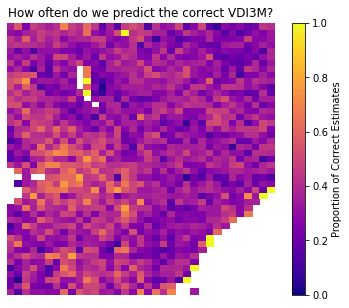

In [24]:
def plot_correct_predictions(pred, true, mask, ax=None) -> plt.Axes:
    """"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5))
    
    img = ax.pcolor(
        (pred == true).mean(dim='time').where(~mask).values,
        cmap='plasma',
        vmin=0, vmax=1
    )
    cbar = plt.colorbar(img, ax=ax)
    cbar.ax.set_ylabel("Proportion of Correct Estimates");
    
    ax.axis('off');
    
    return ax

ax = plot_correct_predictions(vdi_pred, vdi_obs, mask)
ax.set_title('How often do we predict the correct VDI3M?');

In [ ]:
# plt_rows = 5
# plt_cols = 2
# fig, axs = plt.subplots(plt_rows, plt_cols, figsize=(6*plt_cols, 5*plt_rows))

# vdi_classes = np.unique(vdi_true.values)
# vdi_class = 1
# for row_ix, vdi_class in enumerate(vdi_classes):
#     ax1 = axs[row_ix, 0]
#     ax2 = axs[row_ix, 1]
#     # do we reproduce the observed spatial pattern
#     (vdi_true == vdi_class).mean(dim='time').where(~mask).plot(ax=ax1, vmin=0, vmax=1)
#     ax1.set_title(f'True VDI = {vdi_class}')
#     (vdi_pred == vdi_class).mean(dim='time').where(~mask).plot(ax=ax2, vmin=0, vmax=1)
#     ax2.set_title(f'Predicted VDI = {vdi_class}')

#     for ax in [ax1, ax2]:
#         ax.axis('off')

### Do correct predictions vary over time?

In [25]:
vdi_obs.stack(pixel=["lat", "lon"])  #.values.flatten().clip(min=1, max=5)
vdi_pred.stack(pixel=["lat", "lon"])  #.values.flatten().clip(min=1, max=5)

<xarray.DataArray 'vdi' (time: 36, pixel: 1575)>
array([[5, 5, 5, ..., 4, 5, 5],
       [5, 5, 5, ..., 3, 5, 4],
       [5, 5, 5, ..., 3, 4, 4],
       ...,
       [2, 3, 4, ..., 3, 5, 4],
       [1, 3, 2, ..., 4, 5, 4],
       [2, 3, 3, ..., 3, 4, 3]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
  * pixel    (pixel) MultiIndex
  - lat      (pixel) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... 6.0 6.0 6.0 6.0 6.0
  - lon      (pixel) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25

### Seasonality

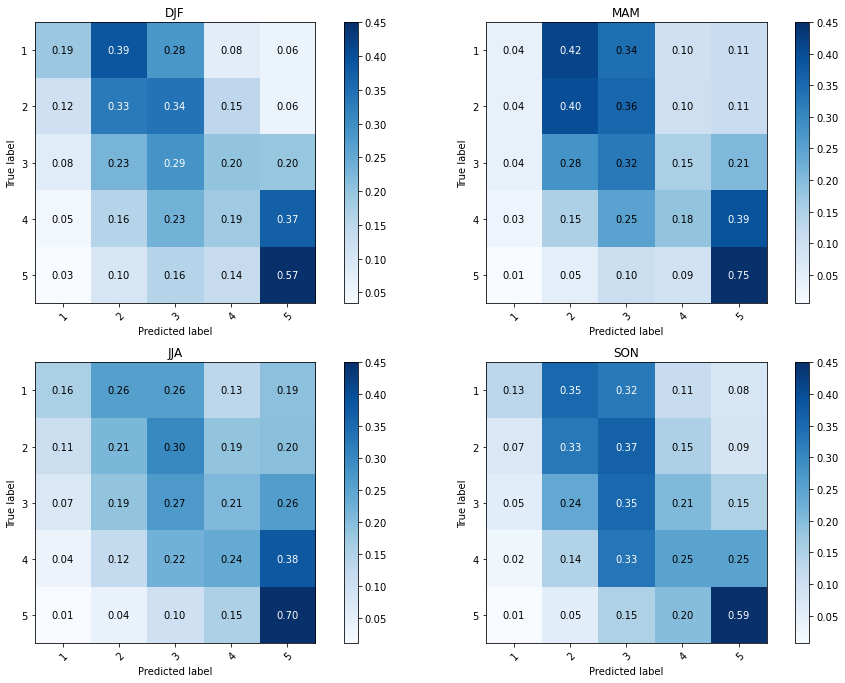

In [27]:
def create_season_ds(vdi):
    vdi['season'] = vdi['time.season']
    return vdi

seasons = ['DJF', 'MAM', 'JJA', 'SON']

scale = 0.6
fig, axs = plt.subplots(2,2, figsize=((12*scale) * 2, (8*scale) * 2))

for ix, season in enumerate(seasons):
    ax = axs[np.unravel_index(ix, (2, 2))]
    season_pred = create_season_ds(vdi_pred)
    season_pred = season_pred[season_pred['season'] == season]

    season_true = create_season_ds(vdi_obs)
    season_true = season_true[season_true['season'] == season]

    vdi_confusion_matrix(
        season_true,
        season_pred,
        normalize=True,
        **dict(vmax=0.45),
        title=season,
        ax=ax
    )

### What about performance per month?

In [29]:
import calendar

def create_month_ds(vdi):
    vdi['month'] = vdi['time.month']
    return vdi

# label dataarray with month and season
month_pred = create_month_ds(vdi_pred)
month_true = create_month_ds(vdi_obs)

# 
all_months = []
for month in range(1, 13):
    n_data_points = len(month_true[month_true.month == month].time)
    
    # how many times do we correctly predict the VDI?
    sum_of_correct = (
        (month_pred[month_pred.month == month] == month_true[month_true.month == month])
        .sum(dim='time')
    )
    sum_of_correct = sum_of_correct.assign_coords(time=month).expand_dims('time')
    
    # create proportion of correct predictions
    prop_of_correct = sum_of_correct / n_data_points
    all_months.append(prop_of_correct)
    
month_errors = xr.concat(all_months, dim='time').where(~mask)

# create dataframe of mean over space
month_df = month_errors.mean(dim=['lat', 'lon']).to_dataframe()
month_df = month_df.reset_index().rename(columns={'time': 'month_id', "vdi": "prop_correct"})
month_df['month'] = month_df.apply(lambda x: calendar.month_abbr[int(x.month_id)], axis=1)
month_df['season'] = ['DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF']
month_df.head()

,month_id,prop_correct,month,season
0,1,0.364357,Jan,DJF
1,2,0.325402,Feb,DJF
2,3,0.291579,Mar,MAM
3,4,0.452298,Apr,MAM
4,5,0.440168,May,MAM


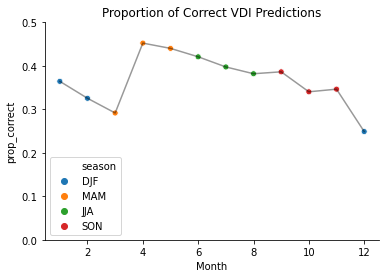

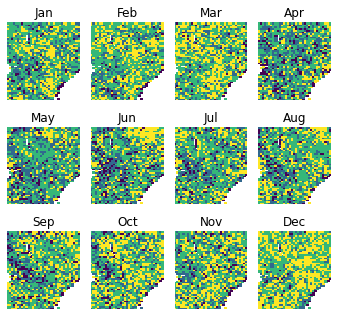

In [30]:
# sns.barplot(x='month', y='prop_correct', hue='season', data=month_df)
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x='month_id', y='prop_correct', data=month_df, color='k', alpha=0.4)
sns.scatterplot(x='month_id', y='prop_correct', hue='season', data=month_df)

# ax.get_legend().remove()
ax.set_ylim(0, 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Proportion of Correct VDI Predictions')
ax.set_xlabel('Month')


## Plot the Maps of each month performance
fig, axs = plt.subplots(3, 4, figsize=(1.2*4, 1.5*3))

for ix, month in enumerate(month_errors.time.values):
    ax = axs[np.unravel_index(ix, (3, 4))]
    month_errors.sel(time=month).plot(ax=ax, cmap='viridis_r', vmin=0, vmax=1, add_colorbar=False, )  # 
    ax.set_title(calendar.month_abbr[month])
    ax.axis('off')
    
plt.tight_layout()

# How far off are we in extreme drought?

In [47]:
vdi_value = 1

# vdi_obs[vdi_obs == vdi_value]
# [~np.isnan(vdi_obs.where(vdi_obs == 1))]

# def get_values_from_
np.nanmean(y_test['boku_VCI'].values[
    ~np.isnan(vdi_obs.where(vdi_obs == 1))
])

29.513695933128687